# Mouse Serial Section Example

In this example we will register the Allen CCF atlas to a mouse Nissl dataset.

First we will walk through an exapmle in this notebook.  

Then we write config files to disk, and run the example from the command line.  The command line interface has only been validated on Linux systems.

## Import libraries

In [1]:
# numpy for multidimensional arrays to store images
import numpy as np
# matplotlib for visualization
import matplotlib.pyplot as plt 
# the command below will allow interactive figures that update as code runs
%matplotlib notebook

# import tools for working with files
from os import makedirs
from os.path import join

# import the json library for writing out config files
import json

# import the subprocess library for running code from command line
import subprocess

# import the emlddmm image registration library
import sys
sys.path.append('../..')
import emlddmm

## Load images

In [28]:
target_name = 'NisslDown/'
atlas_name = 'ara_nissl_50.vtk'
label_name = 'annotation_50.vtk'

<IPython.core.display.Javascript object>


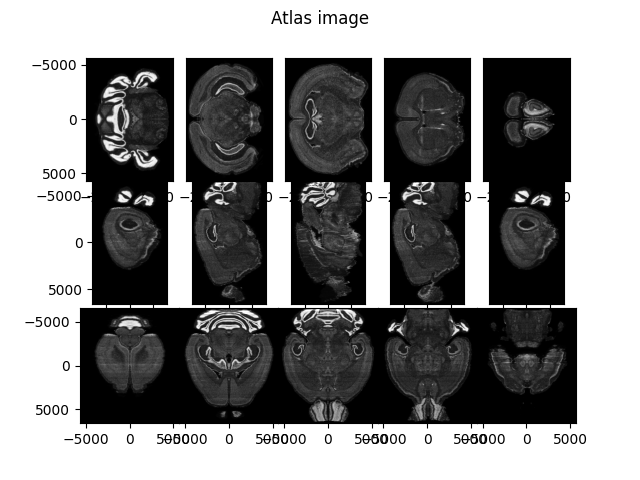

Text(0.5, 0.98, 'Atlas image')

In [29]:
# load the atlas with normalization (mean of abs is 1)
xI,I,_,_ = emlddmm.read_data(atlas_name,normalize=True)
# draw a picture
fig,ax = emlddmm.draw(I,xI,cmap='gray')
fig.suptitle('Atlas image')

<IPython.core.display.Javascript object>


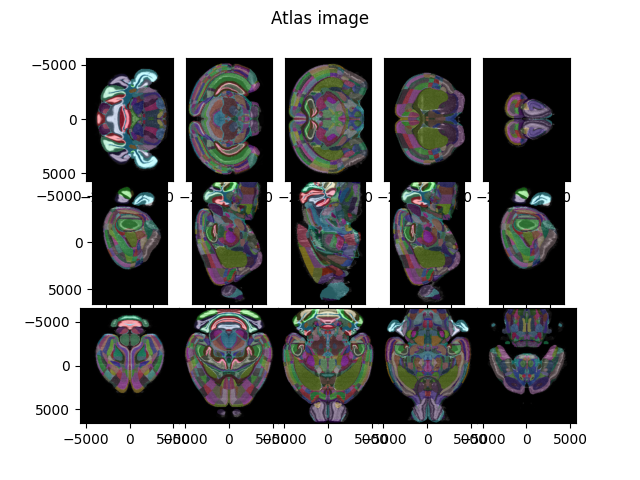

Text(0.5, 0.98, 'Atlas image')

In [30]:
# load the atlas segmentation labels, with no normalization (because these are integer labels)
xS,S,_,_ = emlddmm.read_data(label_name)
SRGB = emlddmm.labels_to_rgb(S)
# draw a picture, showing labels and MRI
fig,ax = emlddmm.draw(SRGB+I/np.max(I)*2.0,xS)
fig.suptitle('Atlas image')

<IPython.core.display.Javascript object>


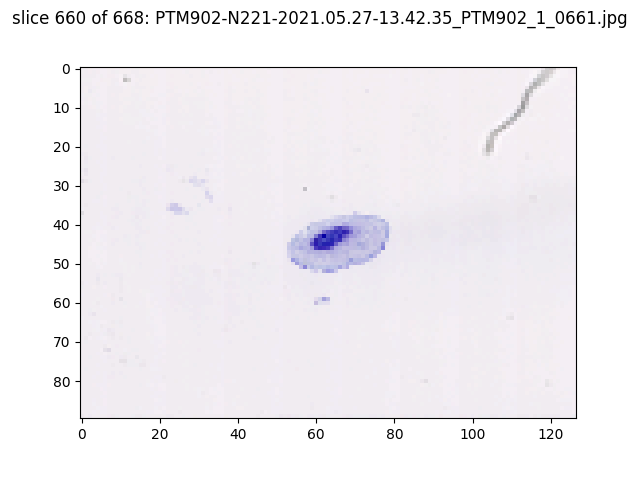

<IPython.core.display.Javascript object>


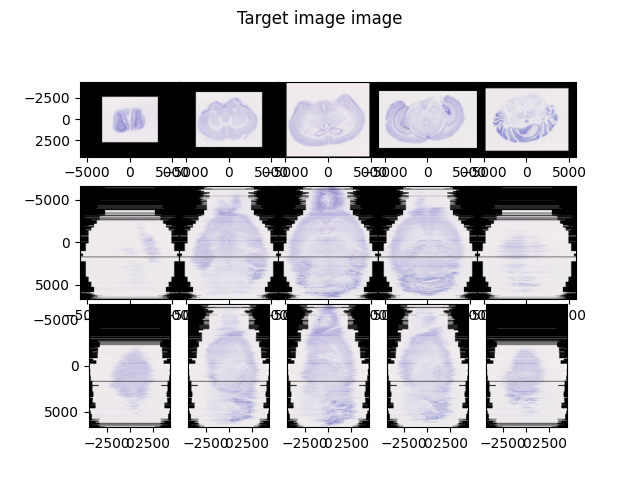

Text(0.5, 0.98, 'Target image image')

In [31]:
# load the target
xJ,J,_,_ = emlddmm.read_data(target_name)
# "weights" for missing data are stored in the last channel
W = J[-1]
J = J[:-1]
# draw a picture
fig,ax = emlddmm.draw(J,xJ,cmap='gray')
fig.suptitle('Target image image')

## Perform an initial "slice to neighbor" alignment

<IPython.core.display.Javascript object>


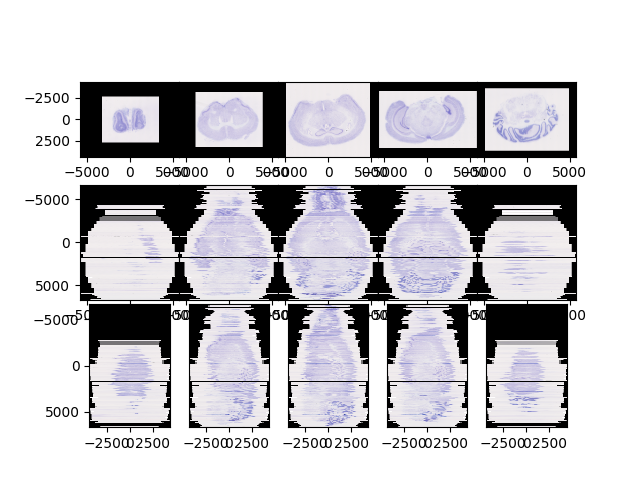

(<Figure size 640x480 with 15 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>]], dtype=object))

In [6]:
# downsample, to speed up calculations
xJd,Jd,Wd = emlddmm.downsample_image_domain(xJ,J,[1,2,2],W=W)
emlddmm.draw(Jd,xJd,vmin=0,vmax=1,interpolation='none')

../../emlddmm.py:4984: RuntimeWarning: divide by zero encountered in true_divide
  op = 1.0 / (xJ[0] - xJ[0][0])
../../emlddmm.py:4986: RuntimeWarning: divide by zero encountered in true_divide
  op = 1.0 / (xJ[0] - xJ[0][0])**2
../../emlddmm.py:4987: RuntimeWarning: divide by zero encountered in true_divide
  op = 1.0 / np.abs((xJ[0] - xJ[0][0]))**1.5/np.sign((xJ[0] - xJ[0][0]))


<IPython.core.display.Javascript object>


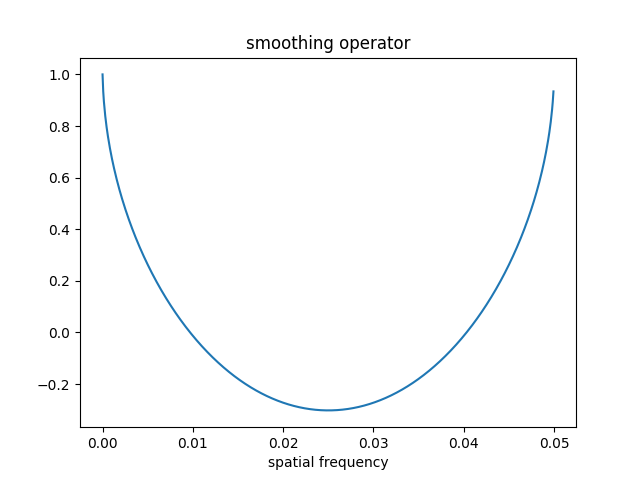

<IPython.core.display.Javascript object>


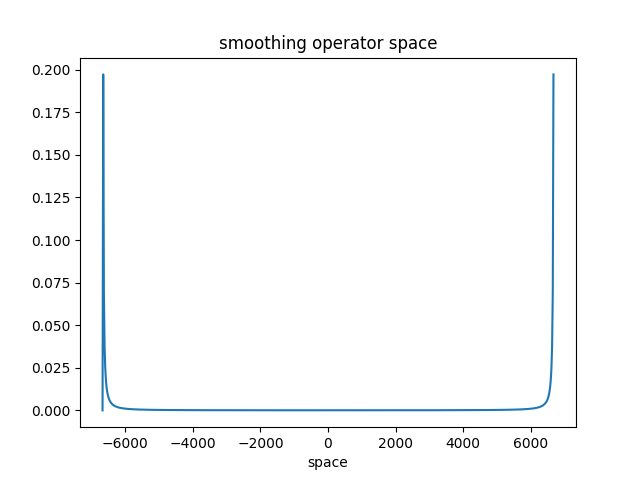

<IPython.core.display.Javascript object>


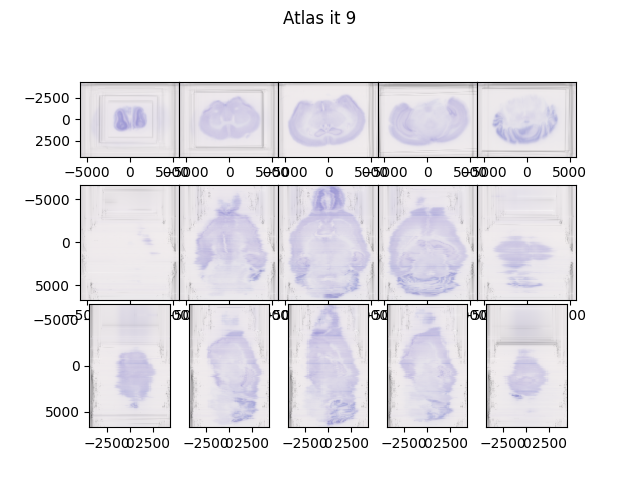

<IPython.core.display.Javascript object>


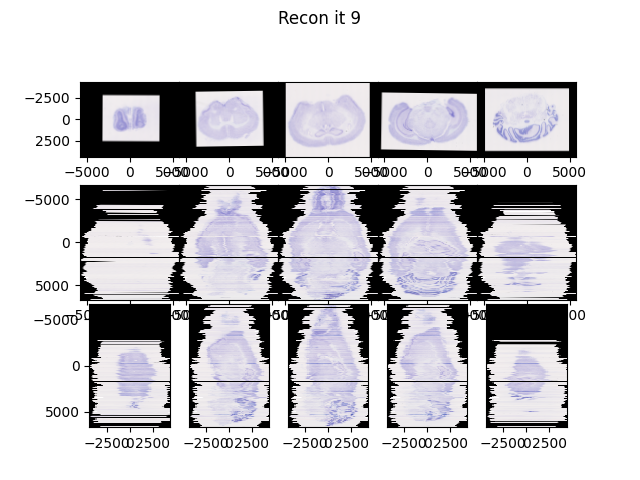

starting it 0


/home/dtward/.local/intelpython3/lib/python3.7/site-packages/torch/autograd/__init__.py:199: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [668, 3, 3], strides() = [9, 3, 1]
param.sizes() = [668, 3, 3], strides() = [9, 1, 3] (Triggered internally at ../torch/csrc/autograd/functions/accumulate_grad.h:202.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


starting it 1


../../emlddmm.py:1404: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A2d = torch.tensor(A2d.detach().clone(),device=device, dtype=dtype)


starting it 2
starting it 3
starting it 4
starting it 5
starting it 6
starting it 7
starting it 8
starting it 9


In [7]:
# run slice to neighbor alignment
import importlib
importlib.reload(emlddmm)
out0 = emlddmm.atlas_free_reconstruction(xJ=xJd,J=Jd,W=(Wd==1),draw=True,n_steps=10,eA2d=2e4)

## Run atlas to slice alignment

In [8]:
config = {
    'device':'cpu', # cpu or cuda:0
    'downI':[[4,4,4],[2,2,2],[1,1,1]], # downsampling factors for the atlas for multi scale
    'downJ':[[1,4,4],[1,2,2],[1,1,1]], # downsampling factors for the target for multi scale. don't downsample in the slice direction (first number)
    'n_iter':[100,50,25], # number of iterations of gradient descent
    'a':[500.0], # spatial scale of the deformation
    'dv':[1000.0], # voxel size to sample the deformation on 
    'muB':[[1.0,1.0,1.0]], # estimate of the intensity of the background (white)
    'muA':[[0.0,0.0,0.0]], # estimate of the intensitiy of artifacts (black)
    'slice_matching':[True], # enable rigid motions over slices
    'v_start':[0], # at which iteration do we start optimizing over the deformation
    'eA':[1e7], # gradient descent stepsize for 3D affine
    'eA2d':[1e5], # gradient descent stepsize for 2D rigid
    'ev':[1e-2], # gradient descent stepsize for deformation
    'local_contrast':[[1,16,16]], # divide the images into small blocks to estimate contrast differences
    'up_vector':[[0.0,0.0,-1.0]], # what vector in the atlas should correspond to "up" in a 2D image
    'sigmaR':[1e4] # regularization for deformation (bigger = less regularization)
}
# intial 2D alignment
config['A2d'] = out0['A2d']
# initial 3D affine
# look at the above figures and assin a letter to each row in order
# A means this row moves from posterior to anterior
# P means this row moves from anterior to posterior
# S means this row moves from inferior to superior
# I means this row moves from superior to inferior
# R means this row moves from left to right
# L means this row moves from right to left
# note that often it is difficult to tell left from right, so we always assume a right handed coordinates
A = np.eye(4)
A[:3,:3] = emlddmm.orientation_to_orientation('ARI','PSL')
config['A'] = A

Found 3 scales


<IPython.core.display.Javascript object>


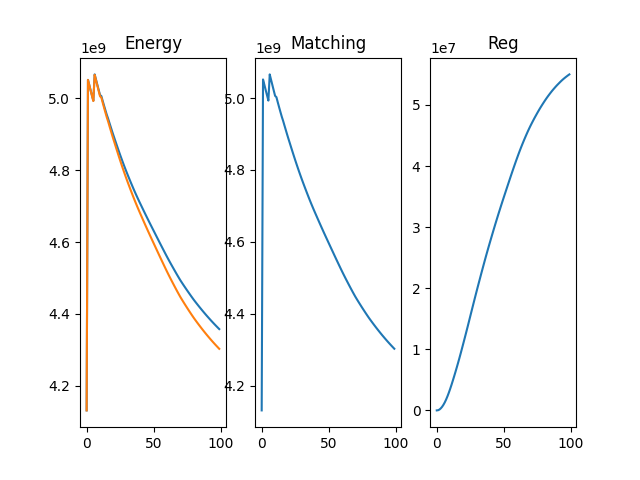

<IPython.core.display.Javascript object>


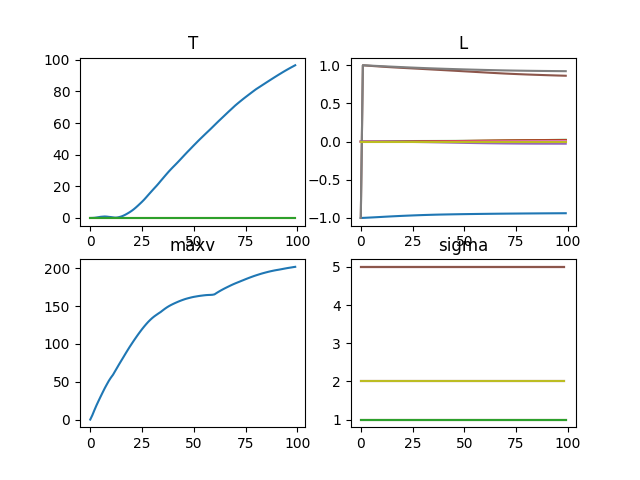

<IPython.core.display.Javascript object>


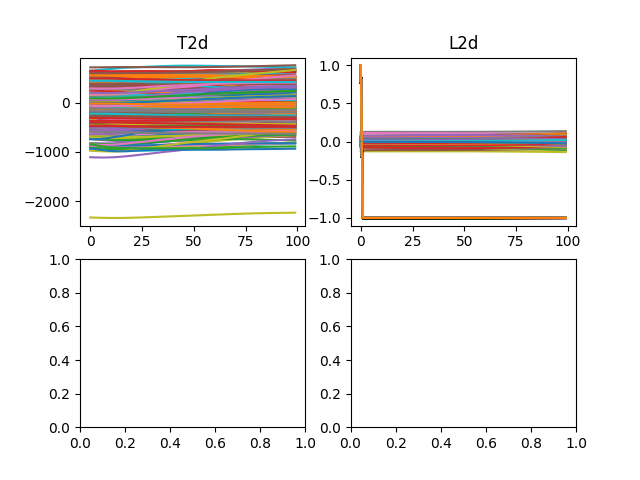

<IPython.core.display.Javascript object>


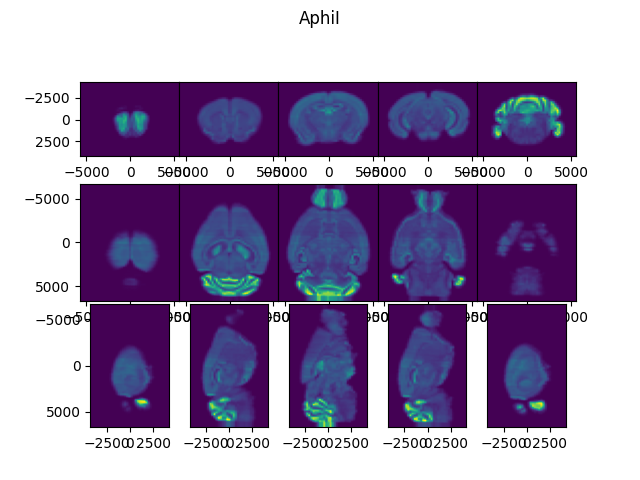

<IPython.core.display.Javascript object>


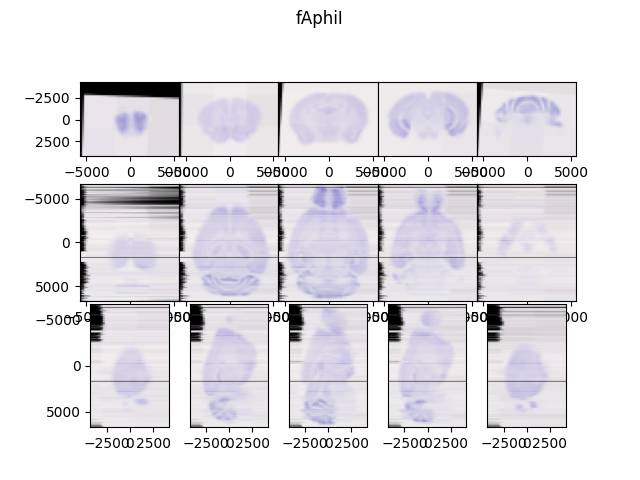

<IPython.core.display.Javascript object>


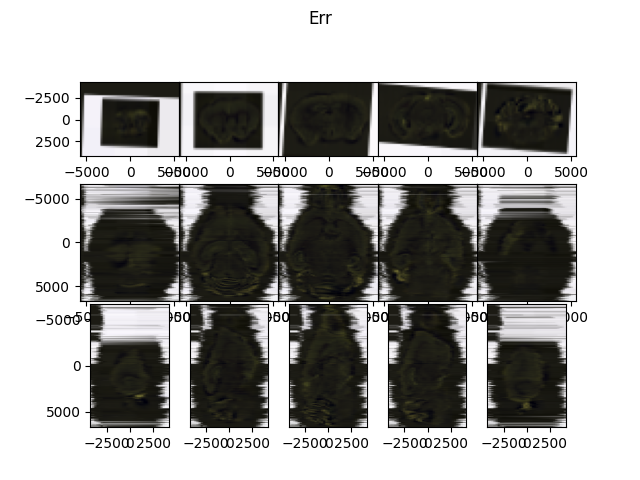

<IPython.core.display.Javascript object>


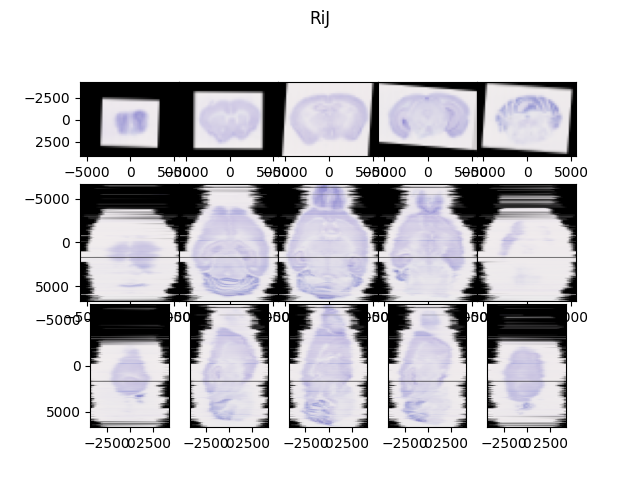

<IPython.core.display.Javascript object>


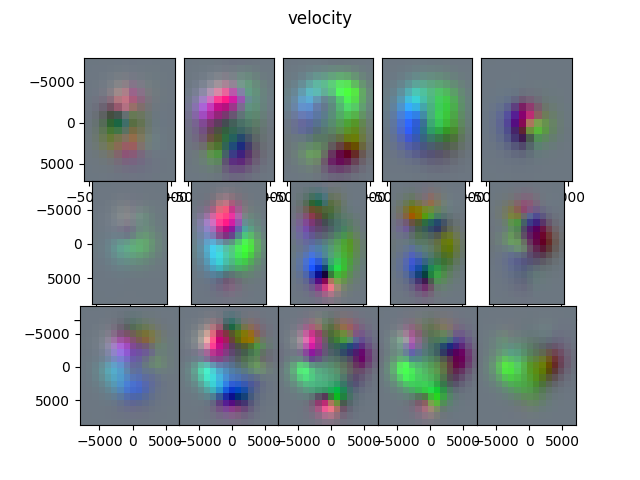

<IPython.core.display.Javascript object>


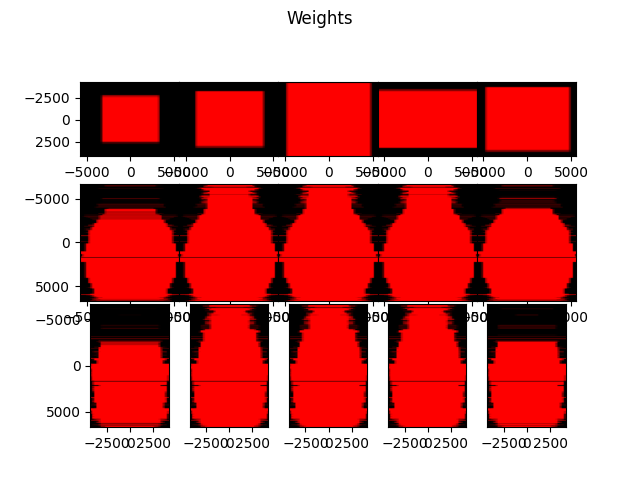

../../emlddmm.py:176: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Iteration 70, linear oscilating, reducing eA to 9000000.0
Iteration 80, linear oscilating, reducing eA to 8100000.0


../../emlddmm.py:1335: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(v.detach().clone(),device=device,dtype=dtype)
../../emlddmm.py:1379: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A.detach().clone(),device=device,dtype=dtype)


<IPython.core.display.Javascript object>


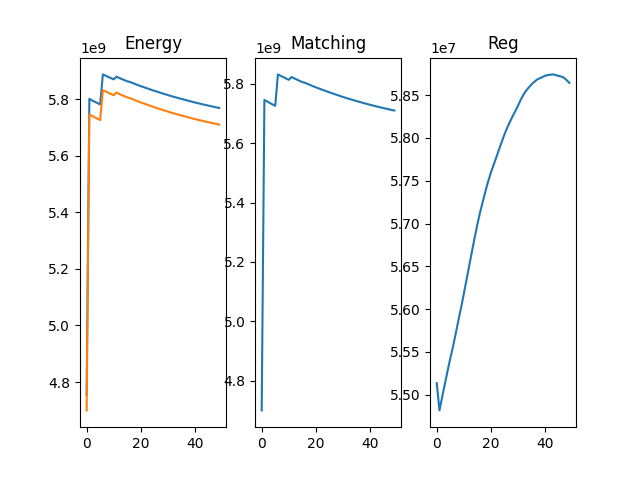

<IPython.core.display.Javascript object>


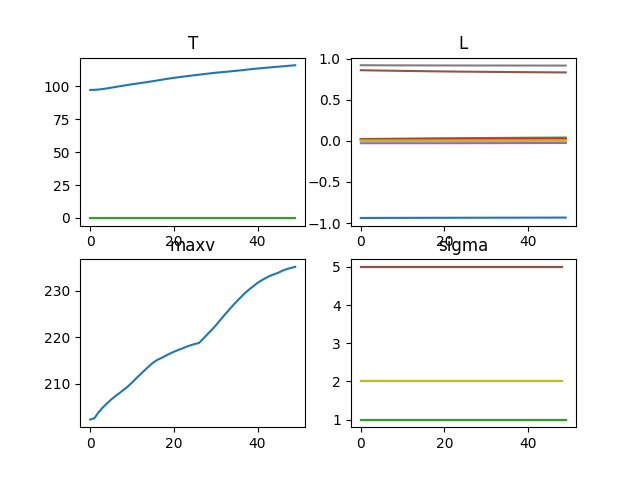

../../emlddmm.py:1449: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figA2d,axA2d = plt.subplots(2,2)


<IPython.core.display.Javascript object>


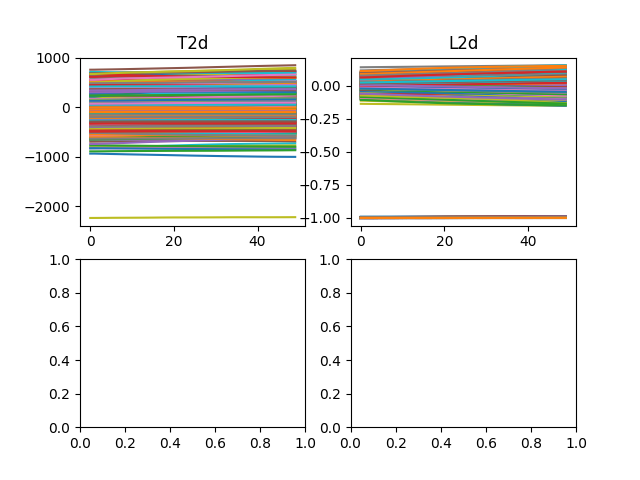

<IPython.core.display.Javascript object>


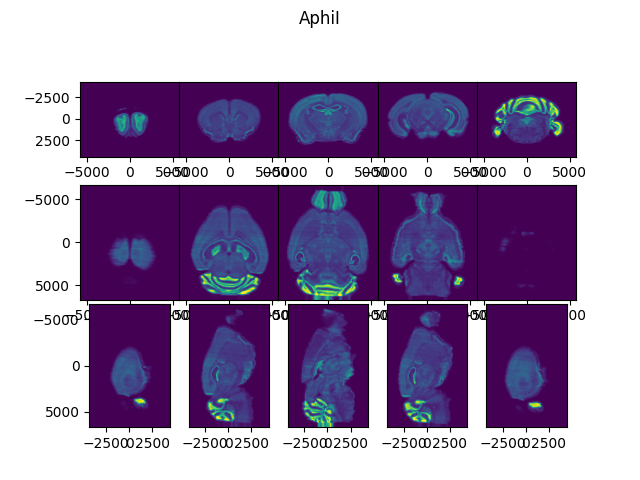

<IPython.core.display.Javascript object>


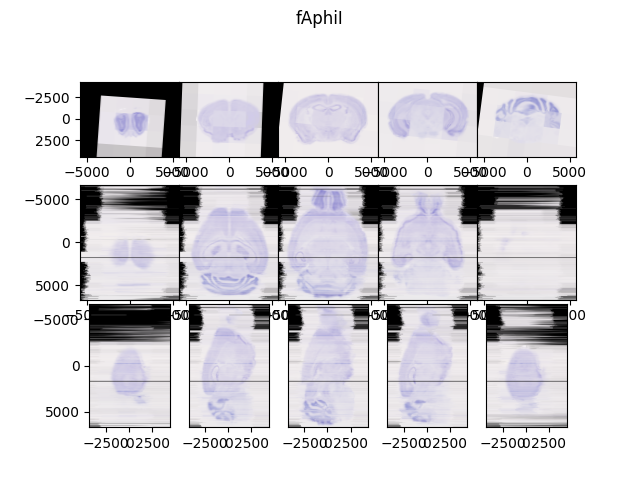

<IPython.core.display.Javascript object>


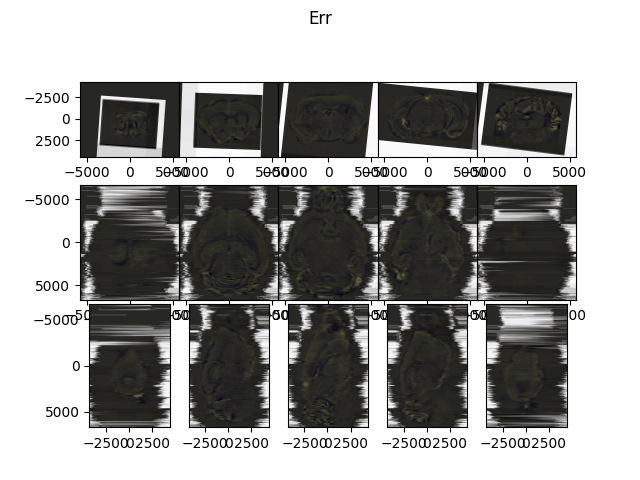

<IPython.core.display.Javascript object>


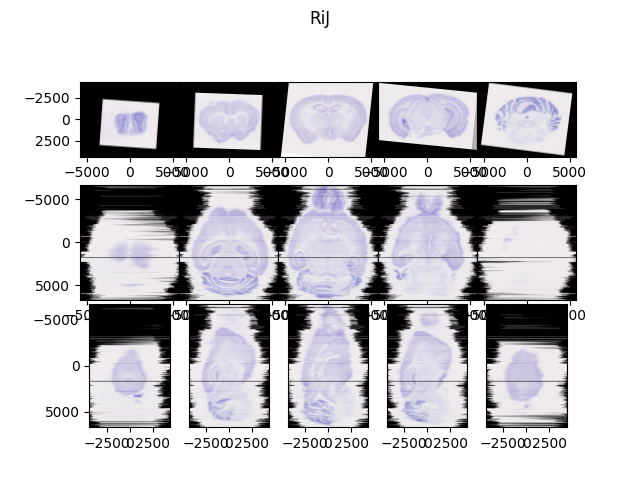

<IPython.core.display.Javascript object>


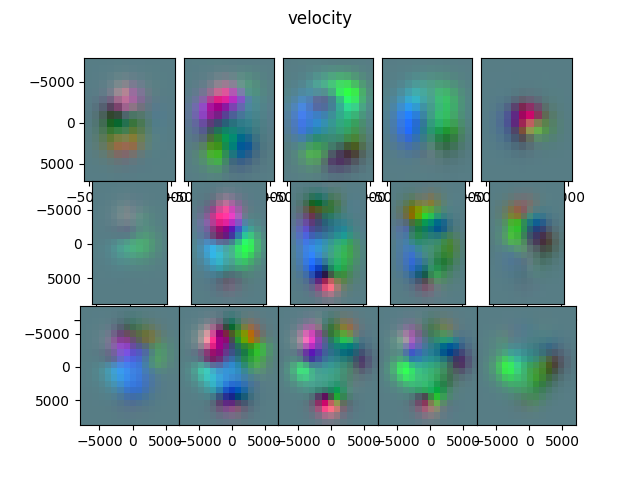

<IPython.core.display.Javascript object>


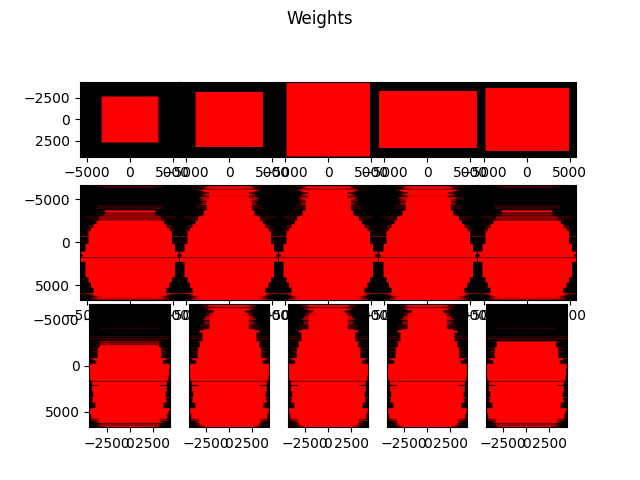

Iteration 20, linear oscilating, reducing eA to 9000000.0
Iteration 40, linear oscilating, reducing eA to 8100000.0


<IPython.core.display.Javascript object>


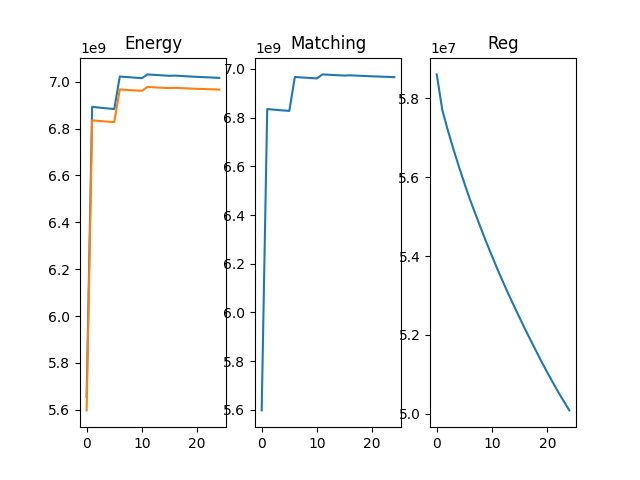

<IPython.core.display.Javascript object>


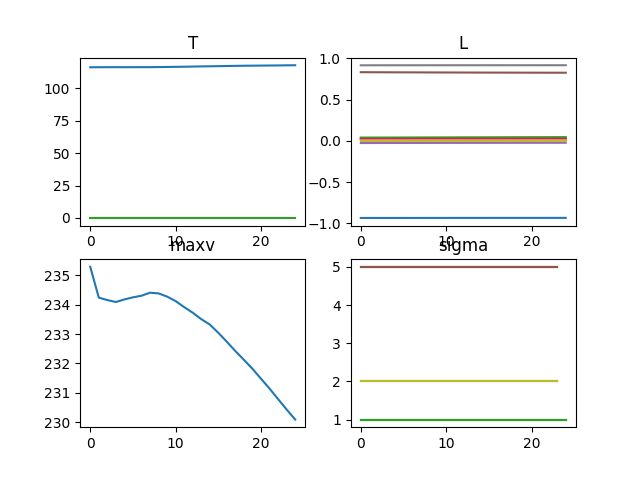

<IPython.core.display.Javascript object>


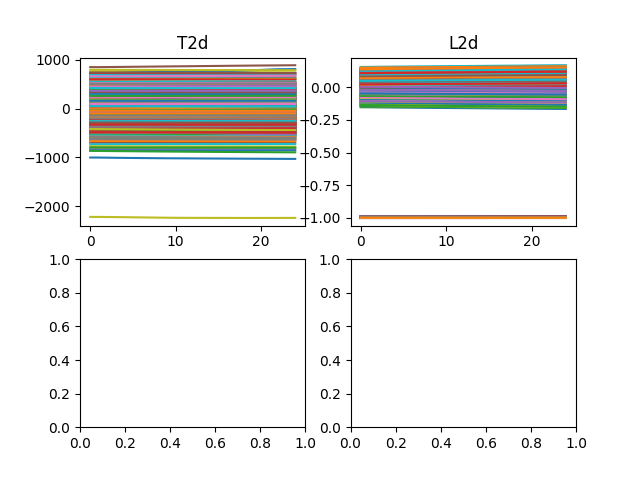

<IPython.core.display.Javascript object>


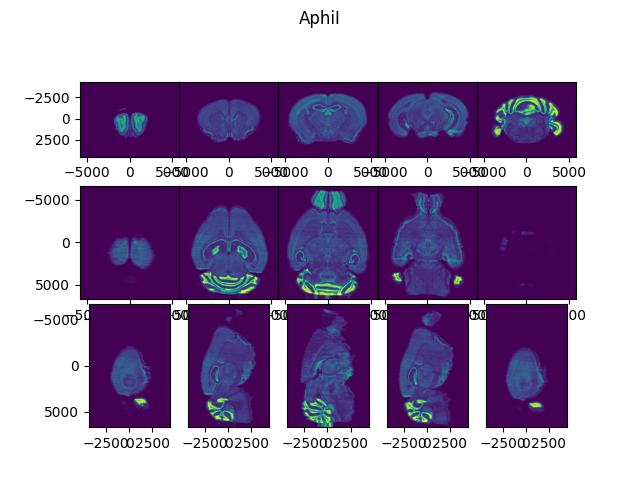

<IPython.core.display.Javascript object>


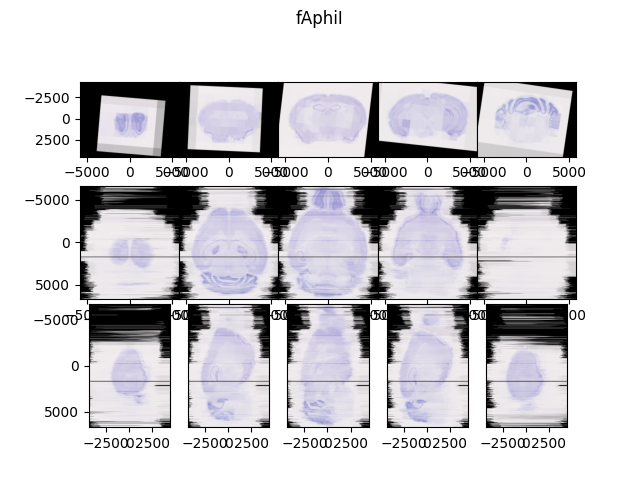

<IPython.core.display.Javascript object>


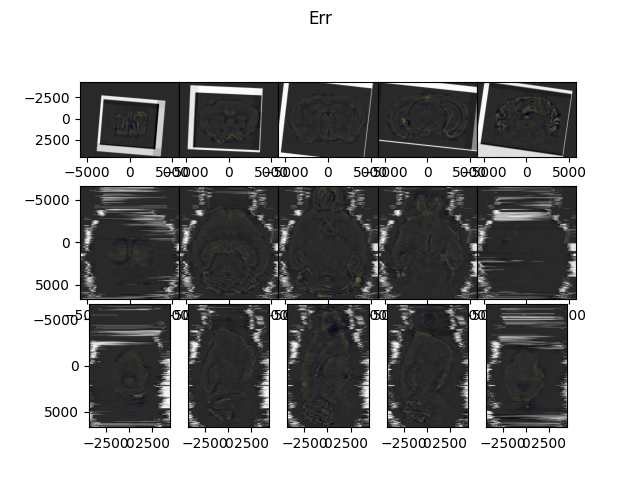

<IPython.core.display.Javascript object>


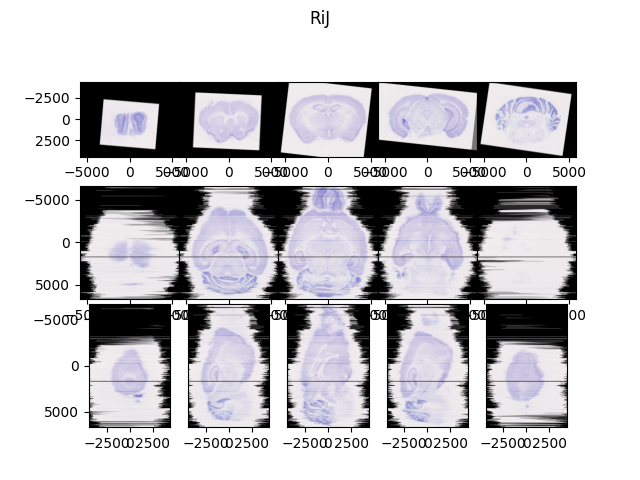

<IPython.core.display.Javascript object>


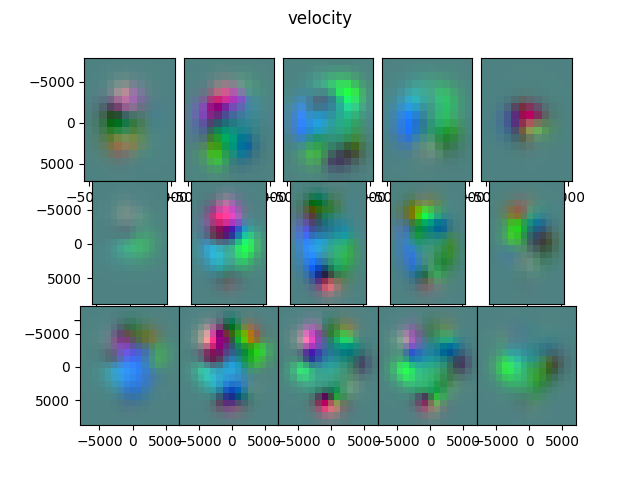

<IPython.core.display.Javascript object>


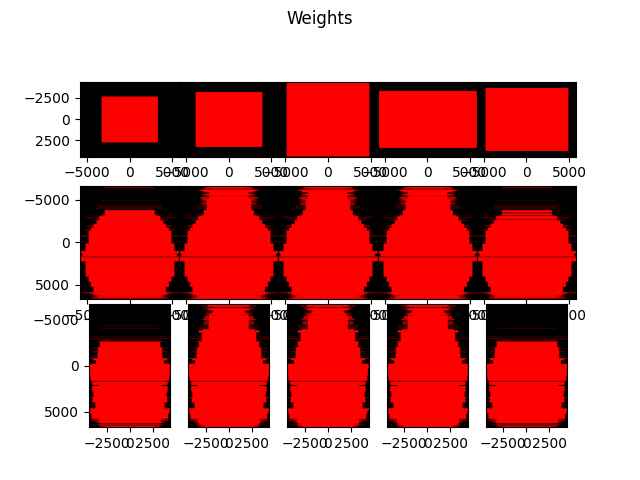

715.610100030899


In [9]:
import time
start = time.time()
import importlib
importlib.reload(emlddmm)
out = emlddmm.emlddmm_multiscale(xI=[xI],I=I,xJ=[xJ],J=J,W0=W,**config)
end = time.time()
print(end-start) # print out the elapsed time, which was reported in the manuscript

## Apply the transform from atlas to registered space

We use the inverse transform.

In [10]:
tform = emlddmm.compose_sequence(
    [        
        emlddmm.Transform(out[-1]['A'],direction='b'),
        emlddmm.Transform(out[-1]['v'],domain=out[-1]['xv'],direction='b'),        
    ],
    xJ
)
AphiI = emlddmm.apply_transform_float(xI,I,tform)
AphiS = emlddmm.apply_transform_int(xS,S,tform)

## Apply the transform from target to registered space
We use the forward transform

In [11]:
tform = emlddmm.compose_sequence(
    [        
        emlddmm.Transform(out[-1]['A2d'],direction='f'),        
    ],
    xJ
)
RiJ = emlddmm.apply_transform_float(xJ,J,tform)


<IPython.core.display.Javascript object>


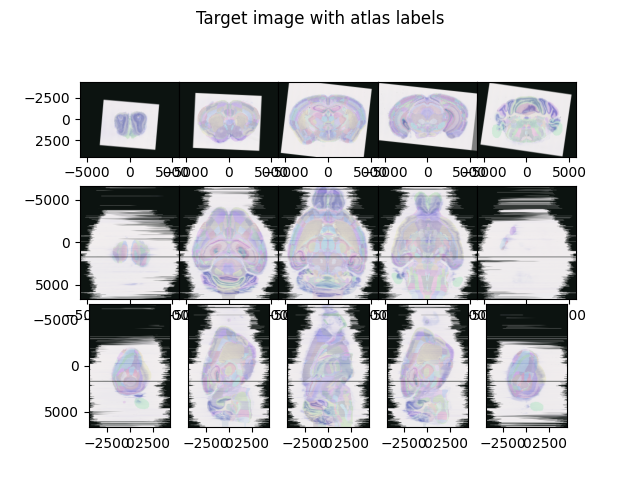

Text(0.5, 0.98, 'Target image with atlas labels')

In [12]:
# draw the labels over the target image
AphiSRGB = emlddmm.labels_to_rgb(AphiS,white_label=0)
# draw a picture, showing labels and MRI
fig,ax = emlddmm.draw(AphiSRGB*0.125+RiJ.numpy()/RiJ.max().numpy()*0.875,xJ)
fig.suptitle('Target image with atlas labels')

## Apply the transform from registered target to atlas space

Interpolation between slices is only meaningful after 2D alignment.  Here we apply a transformation to our aligned Nissl slices.

In [24]:
tform = emlddmm.compose_sequence(
    [        
        emlddmm.Transform(out[-1]['v'],domain=out[-1]['xv'],direction='f'),
        emlddmm.Transform(out[-1]['A'],direction='f'),        
    ],
    xI
)
phiiAiRiJ = emlddmm.apply_transform_float(xJ,RiJ,tform)


<IPython.core.display.Javascript object>


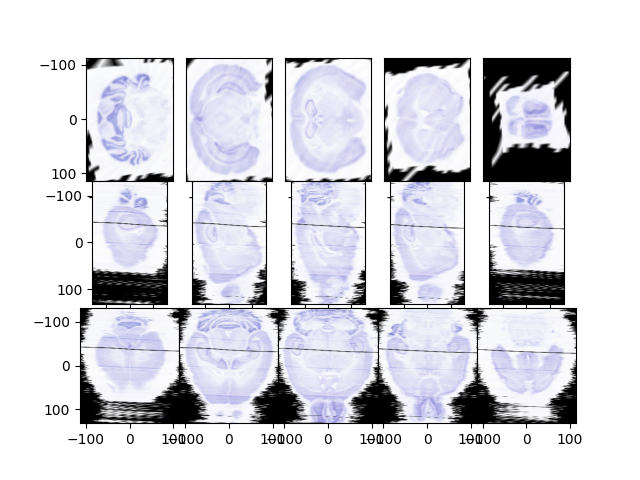

In [27]:
fig,ax = emlddmm.draw(phiiAiRiJ)

## Run this example from the command line

We will write out the parameters above to a config file, and run our command line interface.  This will produce all our standard outputs.

## Write out the registration config file
We'll make sure some of the config inputs are formatted properly as plain text for our config file, and write it out..

In [13]:
config_ = dict(config)
config_['A2d'] = [config_['A2d'].tolist()]
config_['A'] = [config_['A'].tolist()]

In [14]:
config_file = 'atlas_to_target_config.json'
with open(config_file,'wt') as f:
    json.dump(config_,f)

## Write out the transformation graph config file

In [15]:
transformation_config = {
  "output": "output",
  "space_image_path": [
    [
      "Atlas",
      "image",
      atlas_name
    ],
    [
      "Atlas",
      "labels",
      label_name
    ],
    [
      "Target",
      "image",
      target_name
    ],        
  ],
  "registrations": [
    [
      [
        "Atlas",
        "image"
      ],
      [
        "Target",
        "image"
      ]
    ],        
  ],      
  "configs": [
    config_file,   
      
  ],
  "transform_all":True,
}
transformation_config_file = 'transformation_graph_config.json'
with open(transformation_config_file,'wt') as f:
    json.dump(transformation_config,f)

## Run the command

In [16]:
command = f'python -u ../../transformation_graph_v01.py --infile {transformation_config_file} > outputs.txt 2>&1'
print('about to run command:')
print(command)

about to run command:
python -u ../../transformation_graph_v01.py --infile transformation_graph_config.json > outputs.txt 2>&1


In [17]:
subprocess.call(command,shell=True)

0

## View all the outputs

All the output directories are printed below.  Note that this includes a python file graph.p, which contains information about the transformation graph. This will allow us to apply the transforms we have already calculated to new datasets later.

In [20]:
from os import walk
for dirpath,dirnames,filenames in walk('output',):
    for i,f in enumerate(filenames):
        if i >= 3:
            print('...more files for each slice...')
            break
        print(join(dirpath,f))

output/infile.json
output/graph.p
output/Target_registered/Target_to_Target_registered/transforms/Target_registered_PTM902-N1-2021.05.27-15.39.29_PTM902_3_0001_to_Target_PTM902-N1-2021.05.27-15.39.29_PTM902_3_0001_matrix.txt
output/Target_registered/Target_to_Target_registered/transforms/Target_registered_PTM902-N1-2021.05.27-15.39.29_PTM902_2_0002_to_Target_PTM902-N1-2021.05.27-15.39.29_PTM902_2_0002_matrix.txt
output/Target_registered/Target_to_Target_registered/transforms/Target_registered_PTM902-N1-2021.05.27-15.39.29_PTM902_1_0003_to_Target_PTM902-N1-2021.05.27-15.39.29_PTM902_1_0003_matrix.txt
...more files for each slice...
output/Target_registered/Target_to_Target_registered/images/Target_image_PTM902-N1-2021.05.27-15.39.29_PTM902_3_0001_to_Target_registered_PTM902-N1-2021.05.27-15.39.29_PTM902_3_0001.vtk
output/Target_registered/Target_to_Target_registered/images/Target_image_PTM902-N1-2021.05.27-15.39.29_PTM902_2_0002_to_Target_registered_PTM902-N1-2021.05.27-15.39.29_PTM902_